# Final Project - Basics of Mobile Robotics
*December 5th 2024*  
## Professor:
- Francesco Mondada

## Authors:
- Valentin Sutyushev : 388927
- Youri Gandel : 345219
- XXXX  
- XXX

## Tables of contents

- [1) Introduction](#1\)-Introduction)
    - [Libraries used](#Libraries-used)


- [2) Computer Vision](#2\)-Computer-Vision)
    -  [Material and libraries used](#Material-and-libraries-used)
 
todo

## 1) Introduction
### Description of the project
The scope of the project was to have a set of global obstacles which were observed by Computer Vision and avoided by Thymio, without using any sensors. The start and end points are also detected using the Computer Vision. The Computer Vision was done using ArUco Markers from the OpenCV library, due to the ease of the implementation and the obvious white/black contrast. 

After the observation, the optimal path is found using A*. This method was used due to the ease of its implementation. The output was a variable containing a list of tuples to follow for the optimal path.

The control of the robot allows the robot to reach each point from the path variable. A Bayesian filter was necessary to estimate the position and direction of Thymio. Due to the linearity of our system and using the assumption of a Gaussian noise, Kalman Filter was chosen. 

This report is divided in the main sections, namely: **Computer Vision**, **Global Navigation**, **Motion Control**, **Local Navigation** and **Filtering**. Each sections highlights the choices which were made and summarizes how each module is related to others. 

### Environment
The environment definition priories the simplicity. In fact, to decrease the effect of the lightning and different thresholds with different colours, we decided to simply use white and black map. Thus, the background was a single A0 sheet of paper, which contrasts very well with the black obstacles. The obstacles are black and are 2D, thus not triggering the proximity sensors of the Thymio. Those sensors would be manually triggered by a metal cylindric coffee mug. Finally, due to the impossibility of holding the camera perfectly from the top of the map, the map was defined by 4 corners, allowing the warping as if the camera was on top. You may observe an instance of the map below. 

<div style="text-align: center;">
    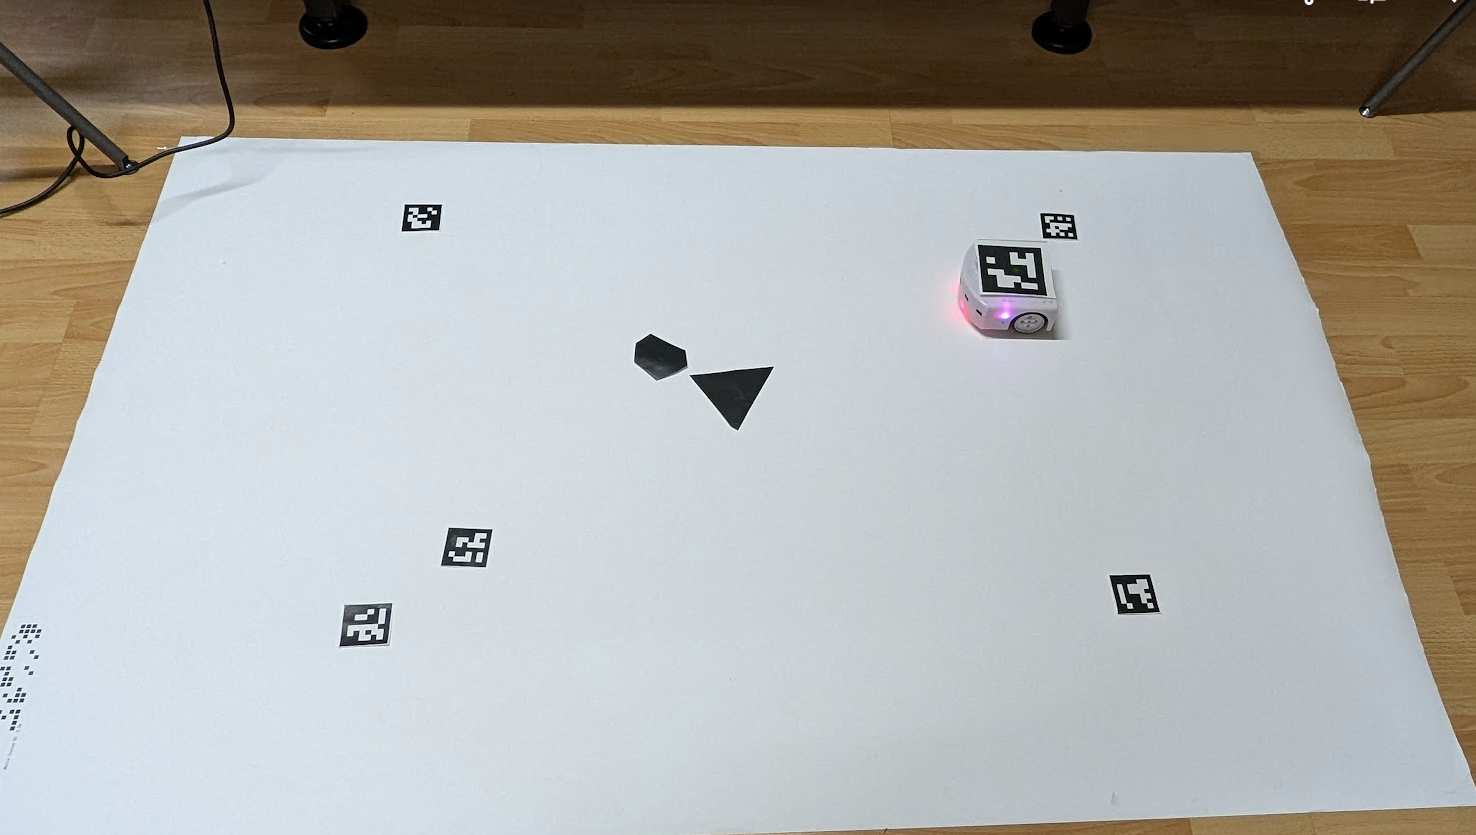
</div>

### Libraries Used
| **Library**     | **Purpose**                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `numpy`         | Numerical computing for linear algebra.                                    |
| `matplotlib`    | Visualization of data, especially for optimal path.                        |
| `heapq`         | Implementation of A* algorithm.                                            |
| `cv2` (OpenCV)  | Computer Vision (ArUco Markers, warping and treshold to get the map.       |


## Videos
Before diving into how the project works at a deeper level, here are some videos that examplify the results we obtained.  
Demonstration: todo  
Local navigation: todo  
Hidden vision: todo  
Kidnapping: todo   



## 2) Computer Vision

### Material and libraries used

As provided in class, the Computer Vision will be done using AUKEY Stream Series 1080P Webcam. The OpenCV library was used for the implementation of the frame processing. In addition, the ArUco Markers were used to simplify the detection of the crucial parts of the map (map limits, obstacles, start and end point).

### Calibration

First step was to calibrate the camera with the appropriate lighting and the used ArUco Markers dictionary (DICT_6X6_250). After generating 50 pictures at different angles, we were able to generate the **'camera_matrix'** and **'dist_coeff'**. This calibration step helped the accuracy and the recognition of the ArUco Markers for the future steps.


In [ ]:
MISSING CODE FOR CALIBRATION 

### Map Recognition

To recognize the map, we decided to put 4 ArUco Markers (AM) at each corner of the map. This way, we can easily define a desired size of the map (which we kept at a proportion of 6:8 to avoid distortion). The markers were placed in a specific order, with a specific order placed inside the map as follows:
- 1: Top-left corner
- 2: Top-right corner
- 3: Bottom-right corner
- 4: Bottom-left corner

Next step was to verify that the shape made by those 4 corners are a rectangle. If it was the case, a red line was drawn directly on the frame to help to correct the AM position, if needed.

The final step was to warp the frame, to get the image as if the fram was taken from a top view. This was done using functions from cv2 library. Specifically, *getPerspectiveTransform* and *warpPerspective* (which can be seen in the code snipet below).

In [ ]:
matrix = cv2.getPerspectiveTransform(rect_corners, dst_corners)
warped_image = cv2.warpPerspective(frame, matrix, (width, height))

The initial frame with the red rectangles defining the map (left) and the warped image (right) can be seen below:

<div style="text-align: center;">
    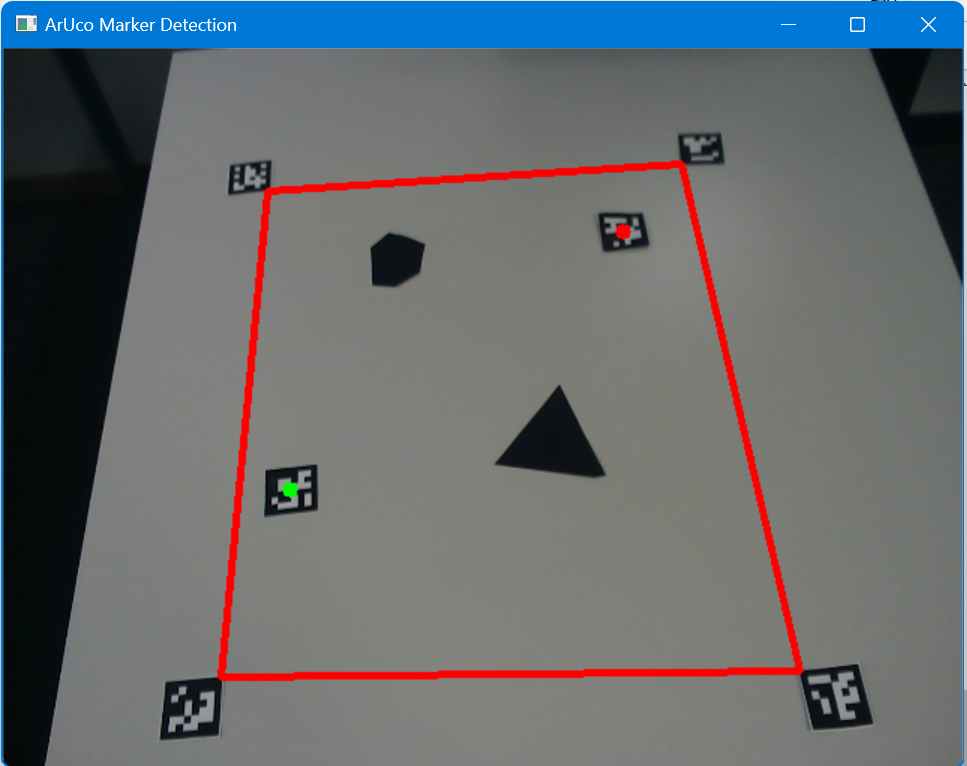
    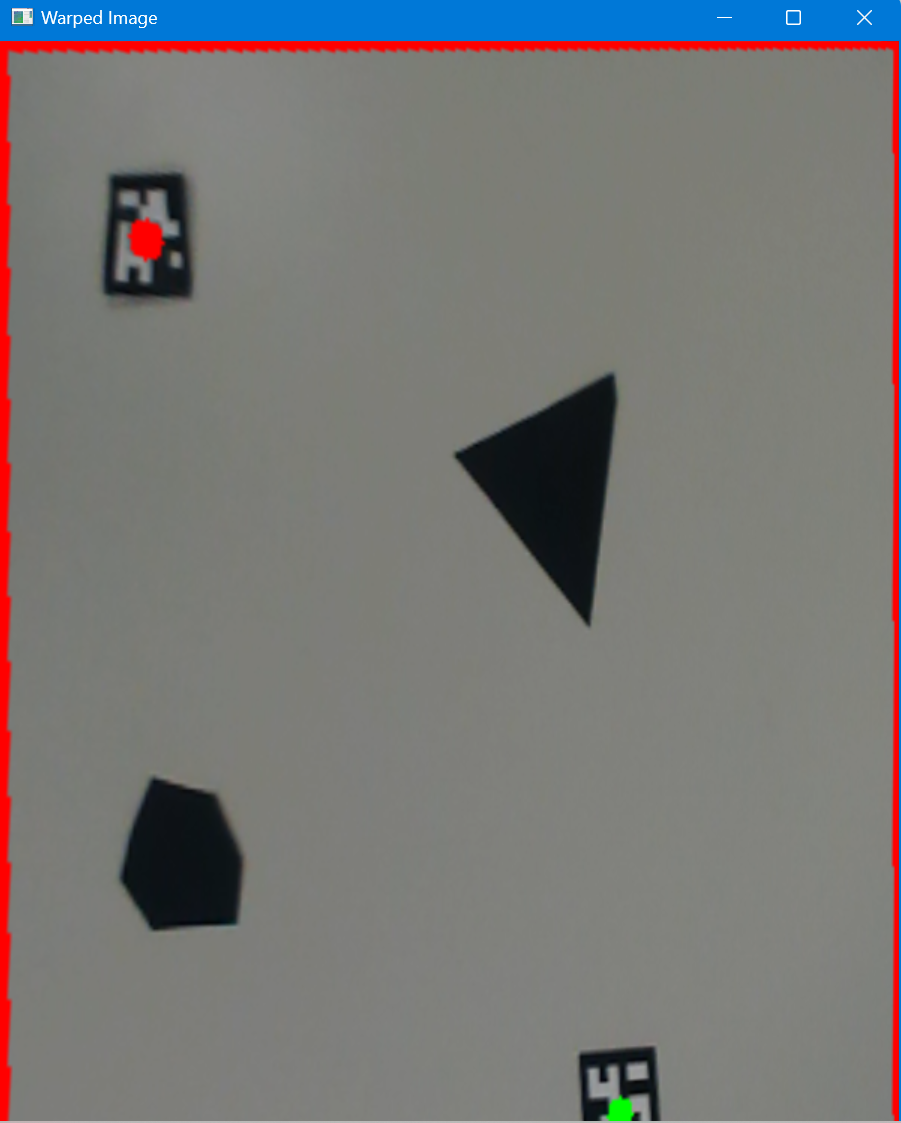
</div>


### Start and End Points Detection and Masking

Due to complication of the detection of AM after the warping, it was decided to detect the start and end points (AM #5 and AM#6) before doing the warping. Indeed, the detection of the AM after warping was extremely sensible to the environment, especially the lightning. A green circle was drawn at the starting position and a red one at the end position.<br/>
<br/>
The biggest issue with using ArUco Markers inside the map was to not confuse them with actual obstacles. To resolve this issue, they were masked using circles. The use of circles was preferred to the rectangles, as due to the warping, the dimension of the rectangle were not constant. Thus, using circles insured that the mask is fully covering the ArUco code. The mask was done using the for-loop shown below:


In [ ]:
for i, marker_id in enumerate(ids.flatten()):
    if marker_id in {5, 6}:  # Mask START (6) and END (5)
        marker_center = np.mean(corners[i][0], axis=0)
        warped_center = cv2.perspectiveTransform(np.array([[marker_center]], dtype=np.float32), matrix)[0][0]
        warped_center_int = tuple(np.clip(warped_center.astype(int), 0, [binary_map.shape[1] - 1, binary_map.shape[0] - 1]))
        cv2.circle(binary_map, warped_center_int, circle_padding, 0, -1)  # Set to white 

### Binary Map

Due to a very simplistic choice of our map, converting the warped image into a binary map was very straightforward. In fact, the warped image was simply converted to a greyscale. Then, using the *threshold* function from cv2 library, which had to be tune according to the appropriate lightning to not consider shade as an obstacle, the binary map was created. Thus, at each obstacle and free space, it has a value of 1 and 0, respectively. 

Note that the binary map contains a value of 3 for starting position pixel and 2 for ending position pixel. However, they are not clearly visible on the map as they only take 1 single pixel.

In [ ]:
gray_warped = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
_, binary_map = cv2.threshold(gray_warped, 100, 255, cv2.THRESH_BINARY_INV)

### Computer Vision Class

The following lines are starting the computer vision block. Thus, activating the camera, detecting the map with the obstacles and start & end position. The output is the binary map variable (**map**), which is the input for the Path Planing module.
```
cv = ComputerVision()
map = cv.get_map()
```
The summarised steps are:

1. **Starting the Camera** : Starting the camera and calibrating it using the camera_matrix and dist_coeff.

2. **Detecting ArUco Markers (AM)** : Detecting 4 AM for the corners, as well as 2 AM for the start and end (goal) position. 

3. **Masking** : Masking the AM for the start and end in order to not confuse them with the obstacles.

4. **Conversion to Binary Map** : Using the rectangle defined by the 4 outside AM to warp the image. Finally, using a threshold, the map was converted to a binary map, which is the outpout of the Computer Vision module. 

<center><img src="Binary_map.png" style="width: 40%; border: 3px solid black;"></center>


## 3) Global Navigation
### General idea
After managing the vision and obtaining a descent output that represents the reality as a map, we calculate an optimal path. To do so, we use the A* algorithm that we learned in class. The output is the best path according to this algorithm that is going to be followed by the motion control module. This class also has the possibility to be called again with a new start after local obstacle avoidance to recalculate a new global path from where the robot is. During calculations several maps are displayed to show what the code does.

### Main steps
1) **Map processing**: The resolution of the input from visualization is too high compared to the size of the robot. To reduce calculation time, the map is processed. The start, goal and obstacles are defined. Then the map is pixelized to a fixed dimensions. So that the robot doesn't get too close to fixed obstacles, they are inflated by a safety number of pixels. That also reduces computation time since some cells won't be explored.
2) **Path-planning**: Once the map is fully vurtually defined, A* algorithm is used to find, if it exists, the shortest path on the grid. Manhattan distances are used as the heuristic for the algorithm. We worked with a 4-connected grid to keep it simpler. This algorithm is detailed in a further section.
3) **Visualisation**: To visualize the map, we reuse the code given in the solution of the exercise 5. It is simplified since all possible areas to go to have the same weight. Black pixels are obstacles, green is the start, red the goal, blue the optimal path, explored cells are in gray and unexplored ones remain white.
4) **Reusability**: In case the case an unexpected local obstacles is on the path, the robot will get around it as programmed in the local navigation module. As it is a kind of reflex that takes Thymio out of the original global path, a new path is calculated from where the robot is.

### A* algorithm
In this section, we will explain more in details how the A* algorithm works as it is the core of the class responsible for global navigation calculations. The goal of this algorithm is to find an optimal path from the start to the goal. 4-connected grid is used. Pixels get assigned different costs that are the following:
- **g(x, y)** is the motion cost. It indicates how many pixels away minimum another pixel is from the start, taking into account obstacles. It is done the same way than the Dijkstra algorithm. Corrdinates on the grid are x and y. In the following code, the origin is on the corner top left, x goes down and y goes to the right.
- **h(x, y)** is the heuristic function. In this case, it is the distance to the goal in straight lines. That means, obscales aren't taken into account.
- **f(x,y) = g(x, y) + h(x, y)** is the total cost. This is the cost used to find an optimal path. A* algoithm will chose pixels with the lowest f-costs. So once costs are calculated, to find an optimal path, the algorithm starts from the goal f-cost and moves to a neighbour cell with the smallest f-cost up to the start. If it cannot, no path exists. That is done thanks to the heapq library that stores pixels according to their associated f-cost so that the algorithm explores the most promising pixels first. 

Here is a visual representation of these costs:  
<img src="images/astar-corr_1.png" alt="gg" width="600"/>  
Image from solutions of exercices 5 of the course : MICRO-452, Basics of mobile robotics.

The reason why we chose this algorithm, apart from the fact that we used it in the exercice 5 session, is because it has some good advantages. It is optimal because it uses an admissible heuristic, meaning that never overestimates the true cost. Moreover A* is efficient as there are less cells explored than for the Dijkstra algorithm. Also, as the grid are simple, computational cost is low. One drawback of this choice of this solution is that it is not necessarily the shortest path in the realworld as the robot only turns with right angles. 


## 4) Motion Control

## 5) Local Navigation

The robot uses front proximity sensors to detect and avoid obstacles dynamically. When an obstacle is detected, the robot adjusts its path to steer clear, using a gradient-based system that changes motor speeds depending on the obstacle's location.

The primary logic:

1. Obstacle Detection: The robot continuously checks its proximity sensors. If any of the front sensors report a value exceeding a defined threshold, an obstacle is considered detected.
2. Avoidance Mechanism:
The robot adjusts its left and right motor speeds based on the proximity readings.
The speed of each wheel is modulated inversely to the proximity readings of sensors on that side. This ensures that the robot turns away from the obstacle.
3. Resolution: Once the obstacle’s proximity falls below a lower threshold, the avoidance sequence ends, and the robot resumes normal navigation.

### Kidnapping
The robot is equipped with a mechanism to detect when it has been picked up or moved off its operating surface—a condition known as "kidnapping." This is achieved using ground proximity sensors, which can distinguish between being on a solid surface and being lifted into the air.

The primary logic:

1. Detecting Kidnapping: When the robot is lifted, it sets a "kidnapped" flag, immediately stops its motors, and waits.
2. Recovery: Once it’s placed back on the ground:
The robot waits a few seconds to stabilize and avoid confusing hands or other objects as part of its environment. A filtering process is run to determine the robot’s current position
and the global path-planning module recalculates a new optimal path to the goal.

## 6) Filtering

## 7) Conclusion

This project allowed us to implement theoretical concepts in a real life project in mobile robotics. By employing tools like A* for pathfinding, Kalman Filters for state estimation, and Computer Vision for obstacle detection and navigation, we gained a deeper understanding on the links of these modules. The Thymio provided a very useful platform to experience the challenges of mobile robotics, especially in managing different environment (lightning and merging diverse modules. This project allowed us to develop our technical skills as well as the transversal skill to work in a team.


## 8) Bibliography
Basics of mobile robotics course: https://moodle.epfl.ch/course/view.php?id=15293  
numpy: https://numpy.org/doc/2.1/reference/index.html  
matplotlib: https://matplotlib.org/stable/users/index  
heapq: https://docs.python.org/3/library/heapq.html  
cv2: https://docs.opencv.org/4.10.0/  
ChatGPT: https://chatgpt.com/  
todo  
todo TDM client?

## 9) Code

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop # For priority queue operations in A* algorithm
import cv2 # For image processing tasks

# Handles the global navigation tasks for the robot, including pathfinding and
# avoiding static obstacles using A* algorithm for graph search 
class AStarNavigation:
    def __init__(self, file_path, safety):
        """
        Initializes the navigation system with a map from vision module and a safety margin.
        
        Parameters:
        - file_path: Path to the text file representing the environment map
        - safety: Minimum safe distance (in pixels) from obstacles.
        """
        self.file_path = file_path # todo modifier pour que var
        self.safety = safety
        self.image = None
        self.start = None
        self.goal = None
        self.map_grid = None
        self.path = None

    def visualization_map(self):
        """
        Reads the environment map from the file, identifies start and goal,
        visualizes the map, and prepares it for pathfinding.
        """
        # Load the text file and convert it to a image
        self.image = np.loadtxt(self.file_path)

        # Find the coordinates of the first occurrence of the digit 2, 3
        self.start = tuple(np.argwhere(self.image == 2)[0])
        self.goal = tuple(np.argwhere(self.image == 3)[0])

        # Replace all occurrences of the digit 2 and 3 with 0 for the map
        self.image[self.start] = 0
        self.image[self.goal] = 0

        # conversion for display
        self.image = np.where(self.image == 0, 255, self.image)
        self.image = np.where(self.image == 1, 0, self.image)

        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()
        
        # Resize the map while maintaining the aspect ratio
        height, width = self.image.shape
        new_width = 60 #todo choose
        new_height = int((new_width / width) * height)
        self.image = cv2.resize(self.image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
        
        # Update the start and goal positions after resizing
        start_y, start_x = self.start
        goal_y, goal_x = self.goal
        self.start = (int(start_y * new_height / height), int(start_x * new_width / width))
        self.goal = (int(goal_y * new_height / height), int(goal_x * new_width / width))
        
        # Display the self.image
        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()
    
        # conversion for path planning
        self.image = np.where(self.image == 0, -1., self.image)
        self.image = np.where(self.image == 255, 0., self.image)

    def safety_distance(self):
        """
        Expands obstacles by the safety distance to ensure the robot doesn't get too close to them.
        Returns a processed grid with expanded obstacle areas.
        """
        # Find the coordinates of all black pixels (value -1)
        black_pixels = np.argwhere(self.image == -1)
        self.image_thick = np.full_like(self.image, 255)
        
        # Iterate through each black pixel and draw a gray border around it
        for pixel in black_pixels:
            y, x = pixel
            cv2.circle(self.image_thick, (x, y), self.safety, 0, -1)
        
        plt.imshow(self.image_thick, cmap='gray')
        plt.axis('off')
        plt.show()
    
        # conversion for path planning
        self.image_thick = np.where(self.image_thick == 0, -1., self.image_thick)
        self.image_thick = np.where(self.image_thick == 255, 0., self.image_thick)
        return self.image_thick

    @staticmethod
    def heuristic(a, b):
        """
        Computes the Manhattan distance between two points as a heuristic for A*.
        
        Parameters:
        - a, b: Tuples representing point coordinates (row, col)
        Returns the Manhattan distance
        """
        # Implement the Manhattan distance heuristic
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def algo(self):
        """
        Implements the A* pathfinding algorithm.
        
        Returns:
        - path: List of points forming the path from start to goal
        - explored: Set of pixells explored during pathfinding
        - operation_count: Number of pixels processed
        """
        # Initialize the open set as a priority queue and add the self.start node
        open_set = []
        heappush(open_set, (self.heuristic(self.start, self.goal), 0, self.start))  # (f_cost, g_cost, position)
    
        # Initialize the came_from dictionary
        came_from = {}
        # Initialize g_costs dictionary with default value of infinity and set g_costs[self.start] = 0
        g_costs = {self.start: 0}
        # Initialize the explored set
        explored = set()
        operation_count = 0
        self.path = []
    
        while open_set:
            # Pop the node with the lowest f_cost from the open set
            current_f_cost, current_g_cost, current_pos = heappop(open_set)
    
            # Add the current node to the explored set
            explored.add(current_pos)
    
            # For directly reconstruct self.path
            if current_pos == self.goal:
                break
    
            # Get the neighbors of the current node (up, down, left, right)
            neighbors = [
                (current_pos[0] - 1, current_pos[1]),  # Up
                (current_pos[0] + 1, current_pos[1]),  # Down
                (current_pos[0], current_pos[1] - 1),  # Left
                (current_pos[0], current_pos[1] + 1)   # Right
            ]
    
            for neighbor in neighbors:
                # Check if neighbor is within bounds and not an obstacle
                if (0 <= neighbor[0] < self.map_grid.shape[0]) and (0 <= neighbor[1] < self.map_grid.shape[1]):
                    if self.map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                      
                        # Calculate tentative_g_cost
                        tentative_g_cost = current_g_cost + 1 + self.map_grid[neighbor[0], neighbor[1]]
    
                        # If this self.path to neighbor is better than any previous one
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            # Update came_from, g_costs, and f_cost
                            came_from[neighbor] = current_pos
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + self.heuristic(neighbor, self.goal)
    
                            # Add neighbor to open set
                            heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                            operation_count += 1
    
        # Reconstruct path
        if current_pos == self.goal:
            path = []
            while current_pos in came_from:
                self.path.append(current_pos)
                current_pos = came_from[current_pos]
            self.path.append(self.start)
            return self.path[::-1], explored, operation_count
        else:
            # If we reach here, no path was found
            return None, explored, operation_count

    def display_map(self, explored):
        """
        Visualizes the map with obstacles, path, start, goal and explored cells
        
        Parameters:
        - explored: Set of explored cells
        """
        cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
        map_display = np.zeros_like(self.image, dtype=object)
    
        # Assign colors based on the map grid values
        map_display[self.image == -1] = 'black'  # Obstacles
        map_display[self.image == 0] = 'white'   # Free space

        for position in explored:
            if map_display[tuple(position)] == 'white':
                map_display[tuple(position)] = 'grey'  # Explored cells
    
        # Visualize the path
        for position in self.path:
            if map_display[position[0], position[1]] in ['white', 'grey']:
                map_display[position[0], position[1]] = 'blue'  # path
    
        map_display[self.start[0], self.start[1]] = 'green'  # Start
        map_display[self.goal[0], self.goal[1]] = 'red'      # Goal
    
        # Convert color names to numbers for plotting
        color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5}
        map_numeric_display = np.vectorize(color_mapping.get)(map_display)
        fig, ax = plt.subplots(figsize=(18, 21))
        ax.imshow(map_numeric_display, cmap=cmap)
        ax.set_xticks(np.arange(-0.5, self.image.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.image.shape[0], 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def solution(self, path, explored, operation_count):
        """
        If a solution exists, solution is displayed
        """
        # Display the result
        if path:
            print(f"{operation_count} operations to find the optimal path")
            self.display_map(explored)
            return path 
        else:
            print("No path found.")
            return None
            
    def run(self):
        """
        Executes the full path-finding pipeline
        """
        self.visualization_map()
        self.map_grid = self.safety_distance()
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)

    def new_path(self, new_y, new_x):
        """
        Computes a new path from a given starting point
        """
        operation_count = 0
        self.start = (new_y, new_x)
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)
        
# calls
file = "images/grid_map_6_8.txt"
safety = 5
navigator = AStarNavigation(file, safety)
path = navigator.run()
#path = navigator.new_path(45, 15)